# Week One

In [1]:
import pandas as pd 
import datetime
from datetime import time
df = pd.read_csv("future_data.csv")
from tqdm import tqdm

In [2]:
df.drop("Unnamed: 0",axis=1,inplace=True)

In [3]:
df.head()

,date,instrument,instrumentid,open,high,low,close,settle,volume,amt_w,oi,comm_ratio,comm_unit,comm_today,margin
0,2018-10-22,a,a1811,0.0,0.0,0.0,3660.0,3660.0,0,0.00,149,0.0,2.0,2.0,0.07
1,2018-10-22,a,a1901,3733.0,3742.0,3704.0,3712.0,3721.0,68429,254681.92,130451,0.0,2.0,2.0,0.07
2,2018-10-22,a,a1903,3740.0,3740.0,3688.0,3701.0,3702.0,7,25.92,40,0.0,2.0,2.0,0.07
3,2018-10-22,a,a1905,3842.0,3842.0,3798.0,3803.0,3812.0,9074,34593.17,19952,0.0,2.0,2.0,0.07
4,2018-10-22,a,a1907,0.0,0.0,0.0,3798.0,3798.0,0,0.00,3,0.0,2.0,2.0,0.07


# 上市时间不满三年

In [4]:
df["date"] = pd.to_datetime(df["date"])

In [5]:
day_last = (datetime.datetime.now() - df.groupby("instrument")["date"].min()).dt.days

In [6]:
day_last_lst= day_last.loc[day_last > 365 * 3].index.to_list()

In [7]:
df = df.loc[df["instrument"].isin(day_last_lst)]

# 代码失效

In [8]:
lapse = ["ER","TC","RO","WS","WT","ME","PM","RI","bb","LR"]
emt_lst = []
for i in df["instrument"]:
    if i not in emt_lst:
        emt_lst.append(i)

In [9]:
for i in lapse:
    if i in emt_lst:
        df.drop(df.loc[df["instrument"] == i].index,axis=0,inplace=True)

In [10]:
len(df["instrument"].value_counts())

51

# 不活跃的品种

In [11]:
inactive = ["wr","WH","RS","JR","fb","CY"]
for i in inactive:
    df.drop(df.loc[df["instrument"] == i].index,axis=0,inplace=True)

In [12]:
len(df["instrument"].value_counts())

45

In [13]:
df.reset_index(drop=True,inplace=True)

# 确定主力合约

In [14]:
# 最近两年的数据
df = df.loc[((datetime.datetime.now() - df.date).dt.days < 365 * 2)]

In [15]:
instrument_lst = []
for i in df["instrument"]:
    if i not in instrument_lst:
        instrument_lst.append(i)
date_lst = []
for i in df["date"]:
    if i not in date_lst:
        date_lst.append(i)
idx = date_lst
cols = instrument_lst

In [16]:
primary = pd.DataFrame(index = idx, columns = cols)
for i in idx:
    for j in cols:
        df_ = df.loc[(df["date"]==i) & (df["instrument"] == j)][["oi","instrumentid"]]
#         print(df_)
        if df_.empty:
            pass
        else:
            idx_max = df_["oi"].idxmax()
            need_value = df_.loc[idx_max, "instrumentid"]
#         print(idx_max)
            primary.loc[i,j] = need_value

KeyboardInterrupt: 

In [ ]:
primary.dropna(axis=0,inplace=True)

In [ ]:
idx_ = primary.index
cols_ = primary.columns
primary_ = pd.DataFrame(index=idx_,columns=cols_)
for i in idx_:
    for j in cols_:
        primary_.loc[i,j] = primary.loc[i,j][-2:]

In [ ]:
for i in cols:
    val_cou = primary_[i].value_counts()
    val_cou_ = val_cou[(val_cou.values /val_cou.sum() - 1/len(val_cou)) / (1/len(val_cou)) >= -0.5]
    print(val_cou_)

In [1]:
import pandas as pd 
import datetime
from datetime import time
from tqdm import tqdm
au20211119 = pd.read_csv("au2021-11-19.csv")

In [2]:
# 删除交易外时间
def drop_out_time(DataFrame):
    idx1 = list(DataFrame.loc[(DataFrame["sys_recv_time"]>"02:30:00") & (DataFrame["sys_recv_time"]<"09:00:00")].index)
    idx2 = list(DataFrame.loc[(DataFrame["sys_recv_time"]>"15:00:00") & (DataFrame["sys_recv_time"]<"21:00:00")].index)
    idx = idx1 + idx2
    DataFrame.drop(idx,inplace=True)
    return DataFrame

# 交易时间转化为真实时间
def fake_to_real(DataFrame):
    fri_index = DataFrame.loc[(DataFrame["dayofweek"]==0)&(DataFrame["trade_date"].dt.time>=time(21,0,0))
                              &(DataFrame["trade_date"].dt.time<=time(23,59,59))].index
    DataFrame.loc[fri_index,"truthtime"] = DataFrame.loc[(DataFrame["dayofweek"]==0)&
                                                    (DataFrame["trade_date"].dt.time>=time(21,0,0))&
                                                    (DataFrame["trade_date"].dt.time<=time(23,59,59))]["trade_date"] - datetime.timedelta(3)

    fri_index_ = DataFrame.loc[(DataFrame["dayofweek"]==0)&(DataFrame["trade_date"].dt.time>=time(0,0,0))
                               &(DataFrame["trade_date"].dt.time<=time(2,30,0))].index
    DataFrame.loc[fri_index_,"truthtime"] = DataFrame.loc[(DataFrame["dayofweek"]==0)&
                                                     (DataFrame["trade_date"].dt.time>=time(0,0,0))&
                                                     (DataFrame["trade_date"].dt.time<=time(2,30,0))]["trade_date"] - datetime.timedelta(2)

    not_fri_index = DataFrame.loc[(DataFrame["dayofweek"]!=0)&(DataFrame["trade_date"].dt.time>=time(21,0,0))&
                                  (DataFrame["trade_date"].dt.time<=time(23,59,59))].index
    DataFrame.loc[not_fri_index,"truthtime"] = DataFrame.loc[(DataFrame["dayofweek"]!=0)&
                                                        (DataFrame["trade_date"].dt.time>=time(21,0,0))
                                                        &(DataFrame["trade_date"].dt.time<=time(23,59,59))]["trade_date"] - datetime.timedelta(1)
    return DataFrame
def get_DataFrame(DataFrame,near,far):
    DataFrame["trade_date"] = DataFrame["udp_date"] + " " + DataFrame["sys_recv_time"]
    df_near = DataFrame.loc[DataFrame["deliv_date"] == near]
    df_far  = DataFrame.loc[DataFrame["deliv_date"] == far]
    trade_date_near = list(df_near["trade_date"])
    trade_date_far  = list(df_far["trade_date"])
    same_date = set(trade_date_near).intersection(set(trade_date_far))
    sorted_date = sorted(same_date)
    sorted_date = pd.to_datetime(sorted_date)
    df_minus = pd.DataFrame(index = range(len(sorted_date)))
    df_minus["trade_date"] = sorted_date
    df_minus["contract1"] = [near] * len(sorted_date)
    df_minus["contract2"] = [far] * len(sorted_date)
    df_minus["dayofweek"] = df_minus["trade_date"].dt.dayofweek
    df_minus["truthtime"] = df_minus["trade_date"]
    df_minus["price1"] = [0] * len(sorted_date)
    df_minus["price2"] = [0] * len(sorted_date)
    return df_minus
# DataFrame:原始数据; near:近月合约；far:远月合约
def execute(DataFrame,near,far):
    df = drop_out_time(DataFrame)
    df_minus = get_DataFrame(df,near,far)
    df_minus = fake_to_real(df_minus)
    df = df.drop_duplicates(subset=["udp_date","sys_recv_time","deliv_date"])
    df = df.sort_values(["udp_date","sys_recv_time","deliv_date"]).reset_index(drop=True)
    df_minus = df_minus.set_index("trade_date")
    df = df.set_index("trade_date")
    return df_minus, df

In [4]:
df_minus,df = execute(au20211119,2112,2206)
for i in tqdm(df_minus.index):
    df_minus.loc[i,"minus"] = df.loc[str(i),:]["lastPrice"][0] - df.loc[str(i),:]["lastPrice"][1]
    df_minus.loc[i,"price1"] = df.loc[str(i),:]["lastPrice"][0]
    df_minus.loc[i,"price2"] = df.loc[str(i),:]["lastPrice"][1]

100%|███████████████████████████████████████████████████████████████████████| 566468/566468 [1:15:30<00:00, 125.03it/s]


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='truthdate'>

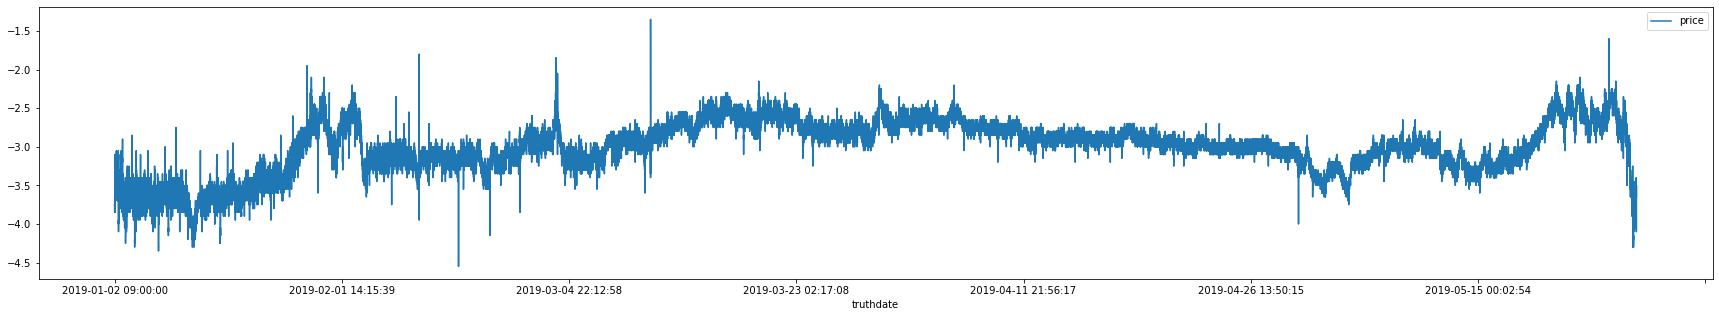

In [1]:
import matplotlib.pyplot as plt
data = pd.read_csv("au1906-1912.csv")
data.plot(x = "truthdate",y = "price",figsize = (30,5))

In [4]:
mean1 = data["price"].quantile(q=0.25)#下四分位差
mean2 = data["price"].quantile(q=0.75)#上四分位差
mean3 = mean2-mean1#中位差
topnum = mean2 + 1.5 * mean3
bottomnum = mean2 - 1.5 * mean3
unnor = data.loc[(data["price"]>topnum) | (data["price"]<bottomnum),"price"]
# print(unnor.values)

# Calendar_Arbitrage

In [27]:
class Calendar_Arbitrage:
    def __init__(self, init_money, shipment,comission, trading_unit,margin_ratio,min_pc,hands):
        self.init_money = init_money                   # 初始资金
        self.shipment = shipment                       # 仓位   
        self.comission = comission                    # 手续费
        self.trading_unit = trading_unit               # 交易单位
        self.margin_ratio = margin_ratio               # 保证金率
        self.min_pc = min_pc                           # 最小变动价位
        self.hands = hands                             # 手数
        
        self.risk_degree = 0
        self.current_interest = init_money
        
        
    def parse_file(self,filepath):
        data = pd.read_csv(filepath)
        return data
    
    def get_abnormal(self,filepath):
        data = self.parse_file(filepath)
        mean1 = data["price1"].quantile(q=0.25)
        mean2 = data["price1"].quantile(q=0.75)
        mean3 = mean2-mean1
        topnum = mean2 + 1.5 * mean3
        bottomnum = mean2 - 1.5 * mean3
        return topnum, bottomnum              # 开仓位
    
    
    def get_normal(self, topnum, bottomnum):
        middle = (topnum + bottomnum) / 2
        distance = topnum - bottomnum
        normal_up = middle + 1/6 * distance
        normal_down = middle - 1/6 * distance
        return normal_up, normal_down     #  平仓位
    
        
    # 是否风险过高  
    def whether_high_risk(self, risk_degree):
        if risk_degree < self.shipment:
            return False
        else:
            return True
        
#     # 流动性是否足够    
#     def whether_lack_liquidity(self,liquidity):
#         if liquidity < 10: # 需要修改
#             return True
#         else:
#             return False
        
#     # 近月合约是否即将到期   
#     def whether_recent_expires(self,date):
#         if date < 20:
#             return True
#         else:
#             return False
    
    # 保证金  (y)
    def get_margin(self, current_price):
        margin = current_price * self.trading_unit * self.margin_ratio
        margin = margin * self.hands
        return margin
    
    # 手续费
    def get_comision(self):
        all_comission = self.hands * self.comission
        return all_comission
    
    # 盈亏 （y）
    def profit(self, price, next_price, direction):
#         all_comission = self.get_comission()
        earnings = 0
        if direction == "more":
            earnings = (next_price - price) / self.min_pc * self.trading_unit * self.hands
        if direction == "less":
            earnings = (price - next_price) / self.min_pc * self.trading_unit * self.hands
#         earnings -= all_comission
        return earnings
        
    # 当前权益   (n)
    def get_current_interest(self,earnings):
        self.init_money += earnings
        self.current_interest = self.init_money
        return self.current_interest
        
    # 风险度   
    def get_risk(self,current_price):
        margin = self.get_margin(current_price)
        self.risk_degree = margin / self.current_interest
        return self.risk_degree
    
    # 建仓
    def open_position(self, current_price, next_price,topnum, bottmonum):
        normal_up, normal_down = self.get_normal(topnum,bottomnum)
#         print("开仓位：", topnum,bottomnum)
#         print("平仓位：", normal_up, normal_down)
#         print("current_price",current_price)

        direction = " "   # 很关键的东西 不然 if 里面的东西属于局部变量
    
        if current_price > topnum:
            direction = "less"
        elif current_price < bottomnum:
            direction = "more"
#         margin = self.get_margin(current_price=current_price)
#         high_risk = self.whether_high_risk(self.risk_degree)
        
             
        if current_price > topnum or current_price < bottomnum:
            earnings = self.profit(current_price,next_price,direction)
            self.current_interest = self.get_current_interest(earnings)
            self.risk_degree = np.round(self.get_risk(current_price), 4)
            print("current_price:",next_price,"当前权益:",self.current_interest,"参考风险度:",self.risk_degree)
        else:
            if current_price < normal_up and current_price > normal_down:
                print("current_price",current_price,"止盈","当前权益:",self.current_interest)
                
            
#             print("达到止盈目标!当前权益:{}".format(self.current_interest))
        

    #         print("当前权益：",self.current_interest, "参考风险度:",self.risk_degree)
#         return earnings, self.current_interest, self.risk_degree, normal_up, normal_down
    
#     def open_position_minus(self,current_price, next_price, direction):
#         margin = 69000
#         if_hold = self.whether_hold(0)
#         if_liquidity = self.whether_lack_liquidity(20)
#         if_expires = self.whether_recent_expires(40)

#         if (not if_hold) and (not if_liquidity) and (not if_expires):
# #             init_risk_degree = margin / self.init_money
#             earnings = self.profit(current_price,next_price,direction)
#             current_interest = self.get_current_interest(earnings)
#             risk_degree =  margin / current_interest
#         else:
#             pass
#         return current_interest, risk_degree
        
                        
#     # 平仓
#     def close_position(self, current_price, normal_up, normal_down):
#                 print("达到止盈目标!!! 当前权益：{}".format(self.current_interest))
# #                 print("本次盈亏：{}".format(earnings))
#                 # 释放保证金
#                 self.shipment = 0
#                 self.risk_degree = 0
                
#             else:
#                 pass
#         else:
#             pass
# #             print("风险度过高强行平仓!!! 当前权益:{}".format(self.current_interest))
#         return self.current_interest, self.risk_degree

In [28]:
ca = Calendar_Arbitrage(init_money=1000000, shipment = 0.3, comission= 10, trading_unit=1000,
                        margin_ratio=0.1,min_pc = 0.02,hands=2)

In [29]:
# data = pd.read_csv("df_minus20211119.csv")
# # data = data.loc[8600:,:]
# price_lst = data["price1"].values

In [30]:
ca.get_abnormal("df_minus20211119.csv")

<IPython.core.display.Javascript object>

(388.01, 369.59000000000003)

In [31]:
ca.get_normal(topnum, bottomnum)

(381.87, 375.73)

In [1]:
data = ca.parse_file("df_minus20211119.csv")
price_lst = data["price1"].values
topnum, bottomnum = ca.get_abnormal("df_minus20211119.csv")
for i in range(len(price_lst)-1):
    ca.open_position(price_lst[i], price_lst[i+1], topnum, bottomnum)
    

NameError: name 'ca' is not defined

In [1]:
df_minus20190531 = pd.read_csv("df_minus20190531.csv")
df_minus20191130 = pd.read_csv("df_minus20191130.csv")
df_minus20200531 = pd.read_csv("df_minus20200531.csv")
df_minus20201130 = pd.read_csv("df_minus20201130.csv")
df_minus20210531 = pd.read_csv("df_minus20210531.csv")
df_minus20211119 = pd.read_csv("df_minus20211119.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='trade_date'>

<Figure size 432x288 with 0 Axes>

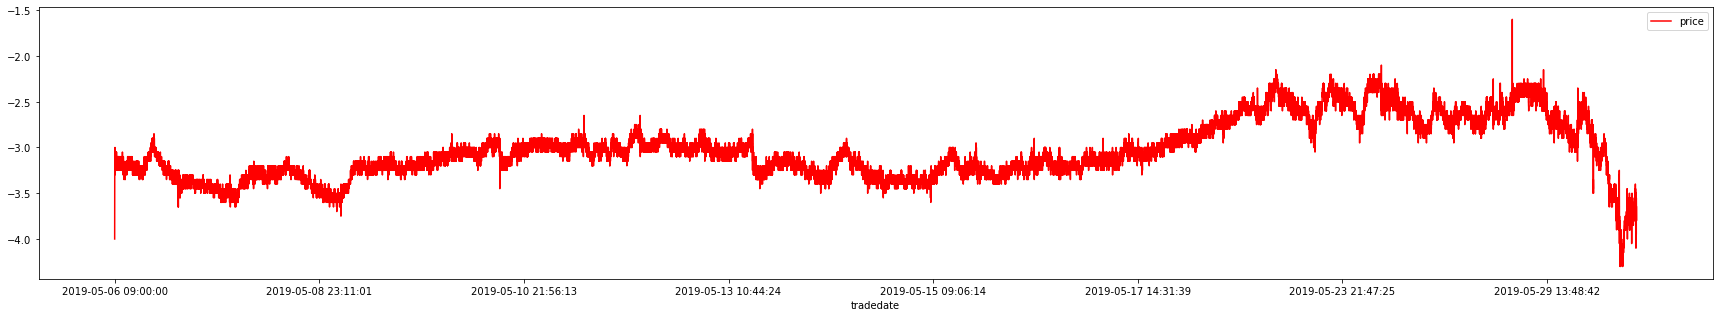

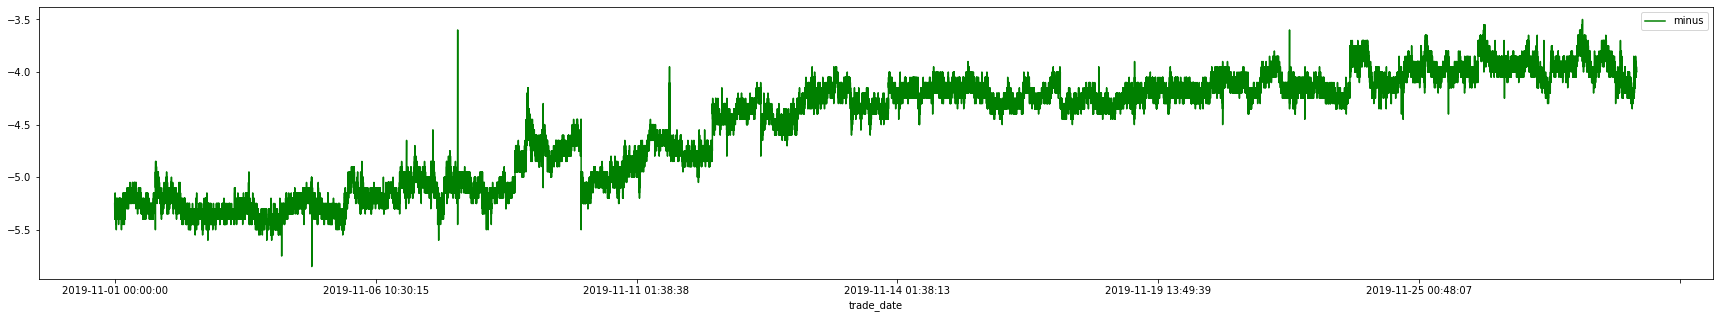

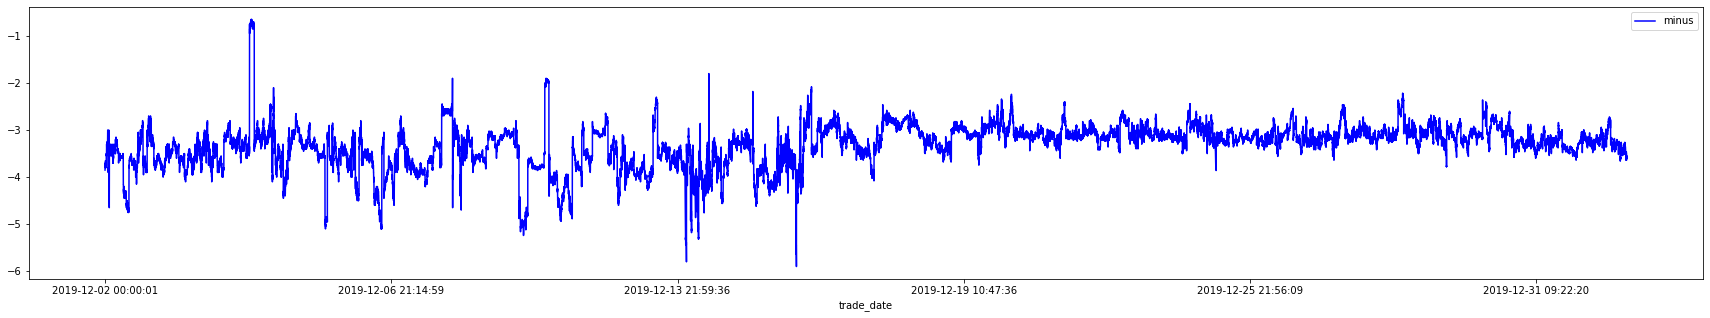

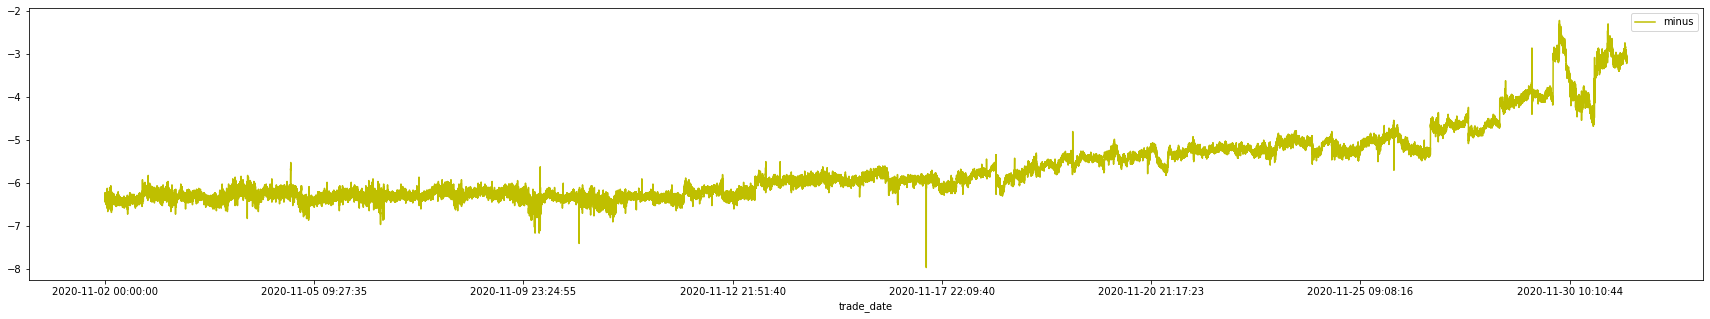

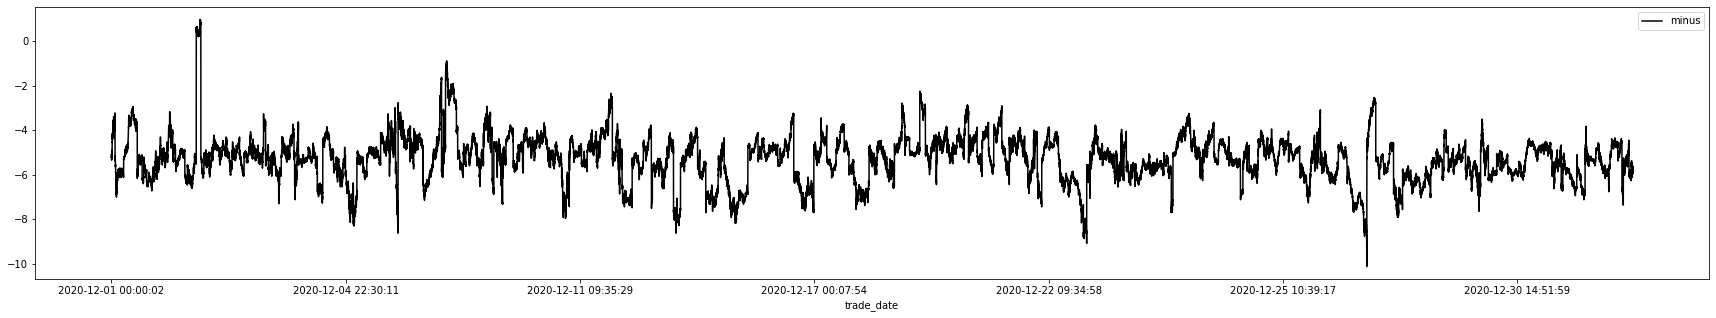

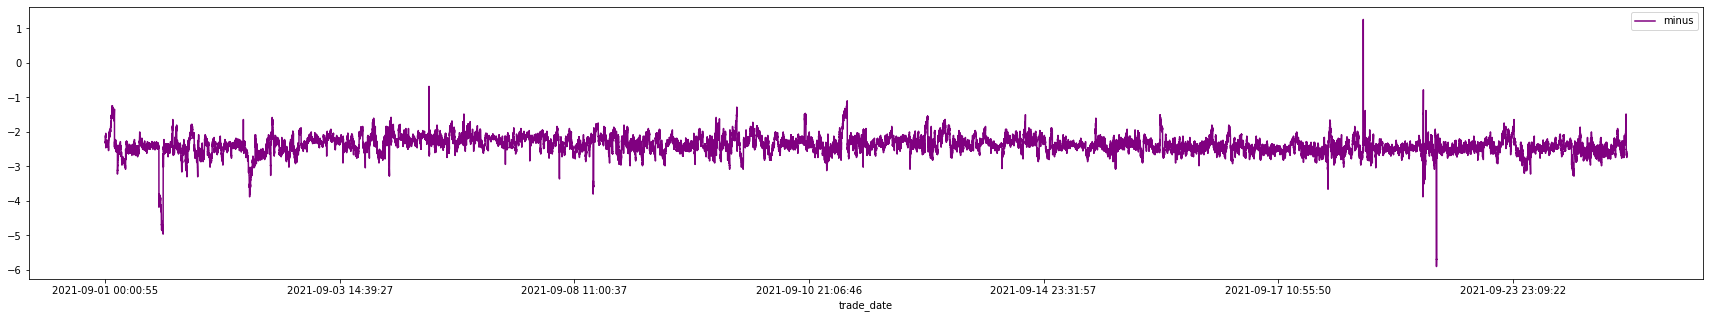

In [109]:
plt.figure()
df_minus20190531.loc[df_minus20190531["tradedate"]>"2019-05-01"].plot(x="tradedate",y="price",c="r",figsize=(30,5))
df_minus20191130.loc[df_minus20191130["trade_date"]>"2019-11-01"].plot(x="trade_date",y="minus",c="g",figsize=(30,5))
df_minus20200531.plot(x="trade_date",y="minus",c="b",figsize=(30,5))
df_minus20201130.loc[df_minus20201130["trade_date"]>"2020-11-01"].plot(x="trade_date",y="minus",c="y",figsize=(30,5))
df_minus20210531.plot(x="trade_date",y="minus",c="k",figsize=(30,5))
df_minus20211119.loc[df_minus20211119["trade_date"]>"2021-09-01"].plot(x="trade_date",y="minus",c="purple",figsize=(30,5))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

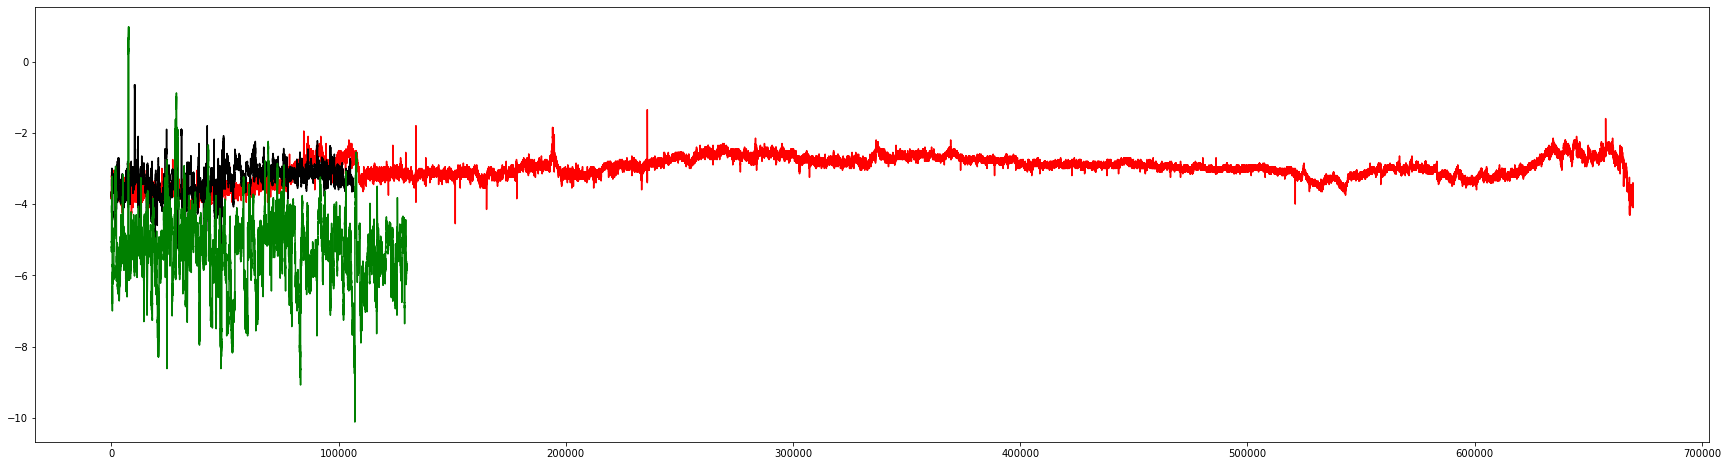

In [40]:
plt.figure(figsize = (30,8))
plt.plot(df1["price"],c="r")
plt.plot(df2["minus"],c="k")
plt.plot(df3["minus"],c="g")
# plt.figsize()

In [67]:
df1 = df_minus20191130.loc[df_minus20191130["trade_date"]>"2019-05-01"]
df1 = df1.reset_index(drop=True)

In [68]:
df2 = df_minus20201130.loc[df_minus20201130["trade_date"]>"2020-05-01"]
df2 = df2.reset_index(drop=True)

In [69]:
df3 = df_minus20211119.loc[df_minus20211119["trade_date"]>"2021-05-01"]
df3 = df3.reset_index(drop=True)

In [76]:
df3["trade_date"] = pd.to_datetime(df3["trade_date"])
df3["pub_time"] = df3["trade_date"].dt.month.astype("str") + "-" + df3["trade_date"].dt.day.astype("str") + " " + df3["trade_date"].dt.time.astype("str")
df3 = df3.set_index("pub_time",drop=True)

<IPython.core.display.Javascript object>

In [84]:
df2["trade_date"] = pd.to_datetime(df2["trade_date"])
df2["pub_time"] = df2["trade_date"].dt.month.astype("str") + "-" + df2["trade_date"].dt.day.astype("str") + " " + df2["trade_date"].dt.time.astype("str")
df2 = df2.set_index("pub_time",drop=True)

<IPython.core.display.Javascript object>

In [85]:
df1["trade_date"] = pd.to_datetime(df1["trade_date"])
df1["pub_time"] = df1["trade_date"].dt.month.astype("str") + "-" + df1["trade_date"].dt.day.astype("str") + " " + df1["trade_date"].dt.time.astype("str")
df1 = df1.set_index("pub_time",drop=True)

<IPython.core.display.Javascript object>

In [99]:
public_time3 = set(df3.index.to_list())
public_time2 = set(df2.index.to_list())
public_time1 = set(df1.index.to_list())

In [108]:
public_time = public_time3.intersection(public_time2).intersection(public_time1)
public_time = sorted(public_time)

In [114]:
df3["2020_minus"] = df2.loc[public_time,"minus"]
df3["2019_minus"] = df1.loc[public_time,"minus"]

In [134]:
df3 = df3.dropna(axis=0)
df3 = df3.rename(columns = {"minus":"2021_minus"})
df3["public_time"] = df3.index.values

<AxesSubplot:xlabel='public_time'>

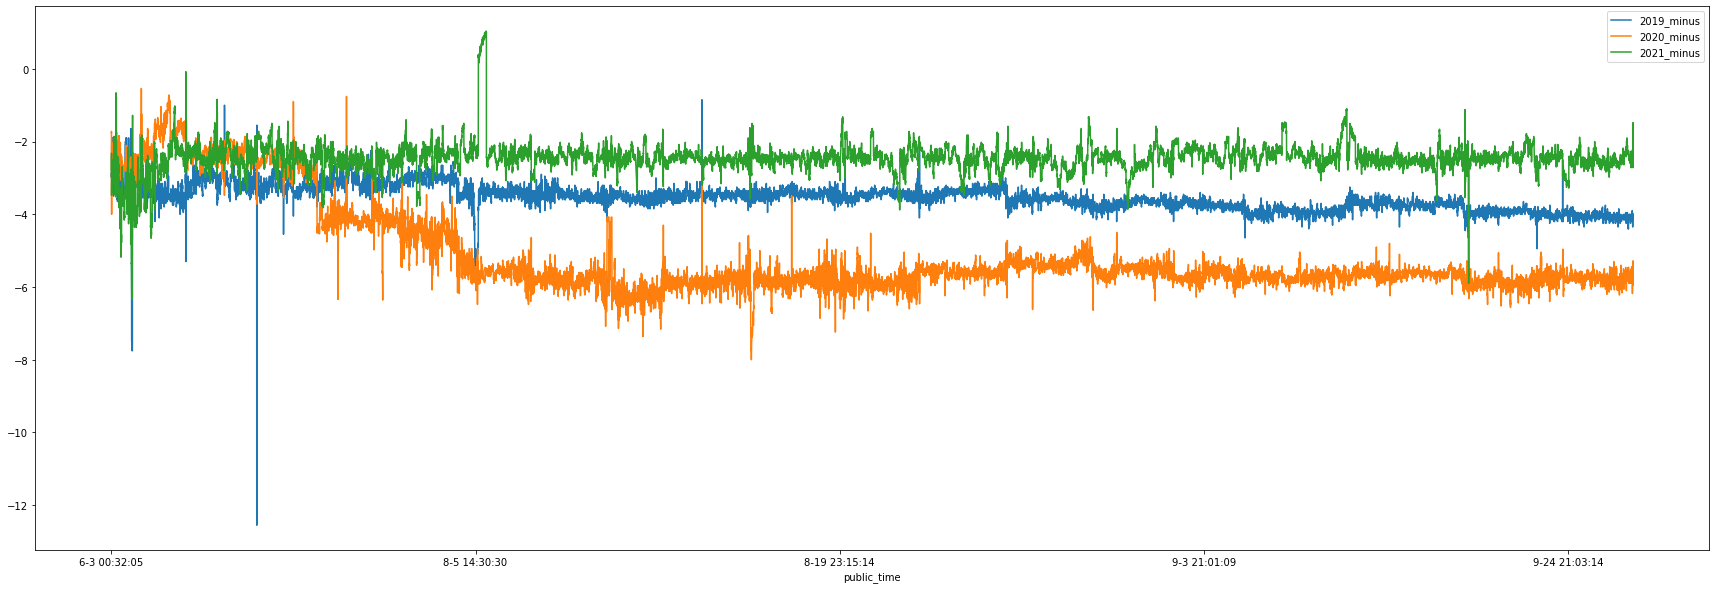

In [140]:
df3.plot(x = "public_time",y = ["2019_minus","2020_minus","2021_minus"],figsize=(30,10))

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='trade_date'>

<Figure size 432x288 with 0 Axes>

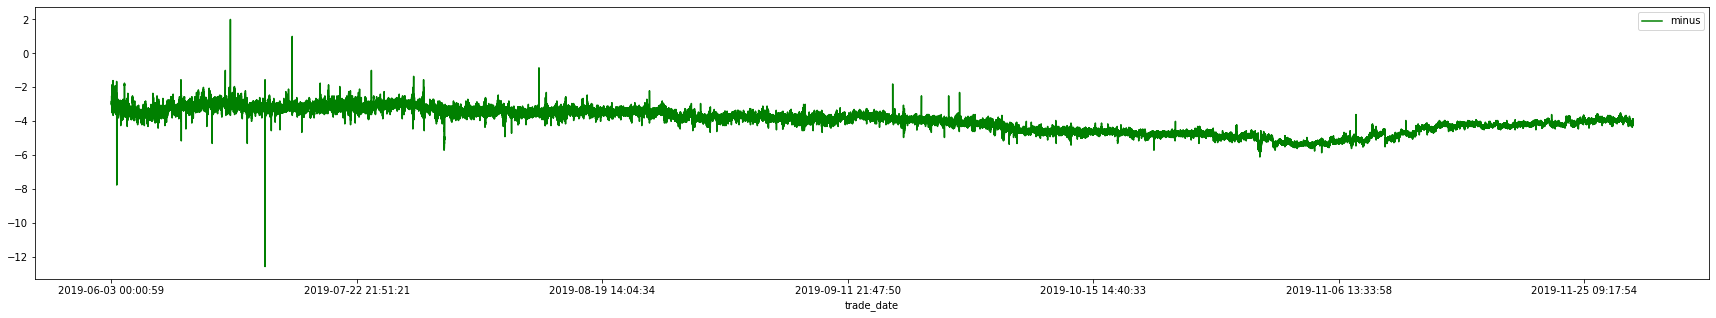

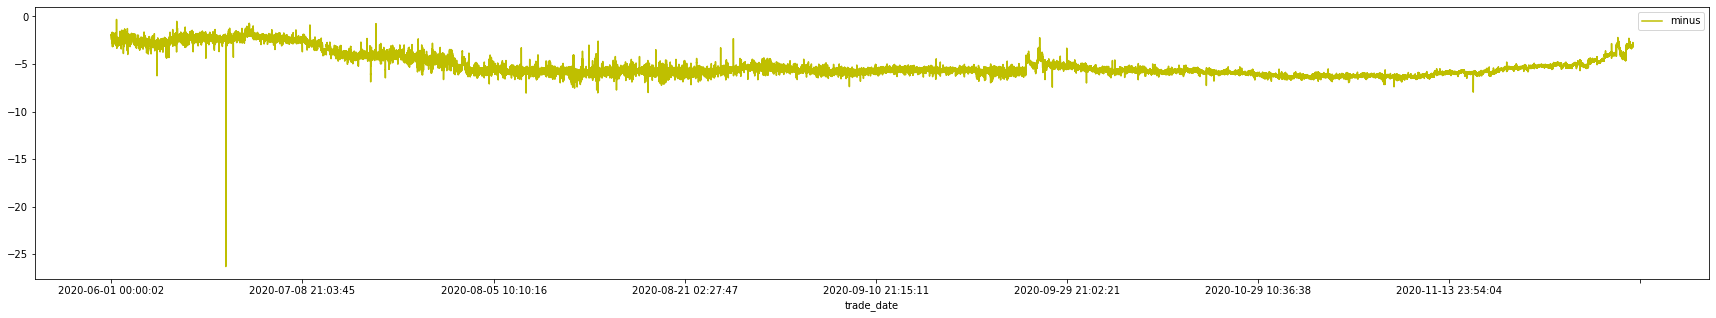

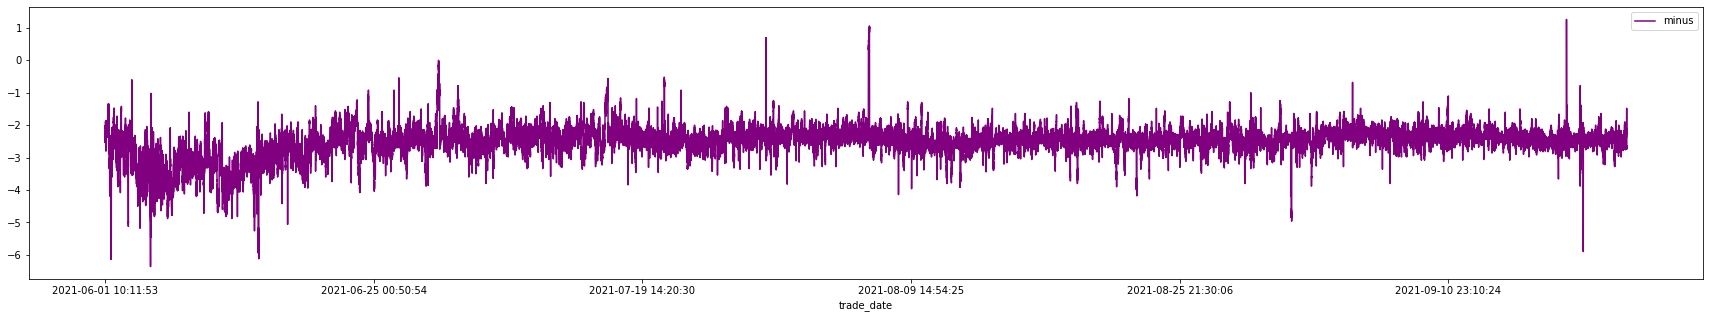

In [143]:
plt.figure()
# df_minus20190531.loc[df_minus20190531["tradedate"]>"2019-05-01"].plot(x="tradedate",y="price",c="r",figsize=(30,5))
df_minus20191130.plot(x="trade_date",y="minus",c="g",figsize=(30,5))
# df_minus20200531.plot(x="trade_date",y="minus",c="b",figsize=(30,5))
df_minus20201130.plot(x="trade_date",y="minus",c="y",figsize=(30,5))
# df_minus20210531.plot(x="trade_date",y="minus",c="k",figsize=(30,5))
df_minus20211119.plot(x="trade_date",y="minus",c="purple",figsize=(30,5))